In [1]:
import re
import dill
import json
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

## Import Datastream Json Objects

'twitter_streaming.txt' was created by twitter_stream.py.

Run command 'python twitter_stream.py > twitter_streaming.txt'
to generate your own data.

In [2]:
tweets_data_path = 'twitter_streaming.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")

for line in tweets_file:
    try:
        tweet = json.loads(line)
        #Check if valid tweet containing text
        if tweet['text']:
            tweets_data.append(tweet)
    except:
        continue

In [3]:
#Working with 21MB of data and fifty-three hundred tweets from about 4 hours of scraping
print len(tweets_data)

5385


In [4]:
tweets = pd.DataFrame()

###Extract data from json to Pandas  DataFrame

In [5]:
tweets['text'] = map(lambda tweet: tweet['text'], tweets_data)
tweets['lang'] = map(lambda tweet: tweet['lang'], tweets_data)
tweets['timestamp'] = map(lambda tweet: tweet['timestamp_ms'], tweets_data)
tweets['retweet_count'] = map(lambda tweet: tweet['retweet_count'], tweets_data)
tweets['hashtags'] = map(lambda tweet: tweet['entities']['hashtags'], tweets_data)
tweets['geo'] = map(lambda tweet: tweet['geo'], tweets_data)

###EDA

####Topic
The purpose of this analysis is to analyze the twitter stream to
determine the trending high-level programming languages. For the
purpose of this analysis, Python and Javascript were tracked.

Running twitter_stream.py for about 4-5 hours provided 5385 tweets.

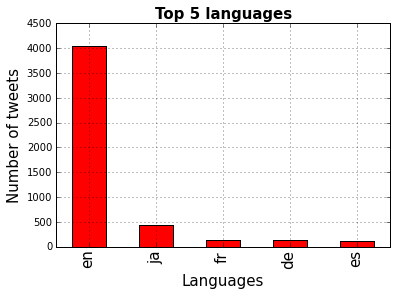

In [6]:
tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red');

In [7]:
def word_in_text(word, text):
    """Regex search for keyword in input text returning boolean."""
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

In [8]:
#Identify tweets containing the keywords in the tweet textbody
tweets['Python'] = tweets['text'].apply(lambda tweet: word_in_text('Python', tweet))
tweets['Javascript'] = tweets['text'].apply(lambda tweet: word_in_text('Javascript', tweet))

In [9]:
#Checking tweet counts to verify both are present
print 'Python Tweet Counts:     ', tweets['Python'].value_counts()[True]
print 'Javascript Tweet Counts: ', tweets['Javascript'].value_counts()[True]

Python Tweet Counts:      1672
Javascript Tweet Counts:  3122


####Exploritory Analysis to see if there are any common subtopics about these languages 

In [10]:
#See if context is coding bootcamps
tweets['Bootcamp'] = tweets['text'].apply(lambda tweet: word_in_text('Bootcamp', tweet))
print tweets.Bootcamp.value_counts()[True]

3


In [11]:
#Are people talking about online courses they took?
tweets['MOOC'] = tweets['text'].apply(lambda tweet: word_in_text('MOOC', tweet))
print tweets.MOOC.value_counts()[True]

1


In [12]:
#Do they need a job?
tweets['Hiring'] = tweets['text'].apply(lambda tweet: word_in_text('Hiring', tweet))
print tweets.Hiring.value_counts()[True]

133


In [13]:
#Are they advertizing an opening?
tweets['Jobs'] = tweets['text'].apply(lambda tweet: word_in_text('Jobs', tweet))
print tweets.Jobs.value_counts()[True]

526


In [14]:
#Talking about it on their resume
tweets['Resume'] = tweets['text'].apply(lambda tweet: word_in_text('Resume', tweet))
print tweets.Resume.value_counts()[True]

9


In [15]:
#Generically talking about coding in the language
tweets['Coding'] = tweets['text'].apply(lambda tweet: word_in_text('Coding', tweet))
print tweets.Coding.value_counts()[True]

66


In [16]:
#Retweet information not provided to client
tweets.retweet_count.max()

0

In [17]:
#Are the tweets geo-tagged
print tweets.geo.loc[tweets.geo.notnull()].count()

7


###Content extraction
The word search revealed that tweets tied to the hiring process were most common.
Tweets with the words 'hiring' and 'jobs' having the highest frequency.  
To look at the the most important concepts of these tweets, the next section will analyze and create word grouping using clustering with 
Non-negative Matrix Factorization. To run the term frequency calculations,
only the English language tweets were considered.

In [18]:
#select english stopwords to remove from term frequency calculation
cachedStopWords = set(stopwords.words("english"))
#add custom words for slang and common abreviations
cachedStopWords.update(('and','I','A','And','So','arnt','This','When','It',\
                        'many','Many','so','cant','Yes','yes','No','no',\
                        'These','these','',' ','ok','na', 'edit','idk',\
                        'gon','wasnt','yt','sure','watch','whats','youre',\
                        'theyll','anyone'))

In [19]:
def lemmatizer(text):
    """Lemmatize all words in tweet texts to eliminate non-words and 
       return the word stems."""
    text = text.lower()

    stemmer = WordNetLemmatizer()
    text = text.encode('ascii', 'ignore')
    text = text.translate(string.maketrans("",""), string.punctuation)

    stop = stopwords.words('english')
    words = [stemmer.lemmatize(word) for word in text.split() if word not in stop]

    return ' '.join(words)

tweets['words'] = tweets.text.apply(lambda x: lemmatizer(x))

In [20]:
#Run TF-IDF to get word frequencies across tweets
vectorizer = TfidfVectorizer(stop_words=cachedStopWords)
tweets['tf_text'] = vectorizer.fit_transform(tweets.words)

In [21]:
#Run Niave Bayes model sentiment binary classifier
#See 'create_sentiment_model.py' for pickle creation.
with open('sentiment_clf_full.pkl', 'rb') as pk:
    clf = dill.load(pk)

In [22]:
tweets['sentiments'] = tweets.words.loc[tweets.lang == 'en'].apply(lambda x: clf.classify(x));
print tweets.sentiments.value_counts()
tweets.sentiments = tweets.sentiments.apply(lambda x: 1 if x=='pos' else -1)

pos    4034
dtype: int64


In [23]:
print "Pos/Neg counts for Python: "
print tweets.loc[tweets.Python == True]['sentiments'].value_counts()
print 
print "Pos/Neg counts for Javascript: "
print tweets.loc[tweets.Javascript == True]['sentiments'].value_counts()

Pos/Neg counts for Python: 
 1    1242
-1     430
dtype: int64

Pos/Neg counts for Javascript: 
 1    2433
-1     689
dtype: int64


In [24]:
def NMF_tkn_words(X, n_features=10000, n_topics=4, n_top_words=4,\
                  random_state=1):
    """
        Non-negative matrix factorization to group tokenized words into
        topic clusters.
    """

    n_samples = X.shape[0]
    #select english stopwords
    cachedStopWords = set(stopwords.words("english"))
    #update list
    cachedStopWords.update(('and','I','A','And','So','arnt','This','When','It',\
                            'many','Many','so','cant','Yes','yes','No','no',\
                            'These','these','',' ','ok','na', 'edit','idk',\
                            'gon','wasnt','yt','sure','watch','whats','youre',\
                            'theyll','anyone'))

    vectorizer = TfidfVectorizer(stop_words=cachedStopWords)
    X = vectorizer.fit_transform(X).toarray()

    # Fit the NMF model
    print("Fitting the NMF model with n_samples=%d and n_features=%d..."
          % (n_samples, n_features))

    nmf = NMF(n_components=n_topics, random_state=random_state).fit(X)
    feature_names = vectorizer.get_feature_names()

    for topic_idx, topic in enumerate(nmf.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]\
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

    return feature_names

In [25]:
def words_in_text(word_list, text):
    """Regex search for keyword in input text returning boolean."""
    text = text.lower()
    for ix,word in enumerate(word_list):
        word = word.lower()
        match = re.search(word, text)
        if match:
            return True
        elif ix < len(word_list):
            continue
        else:
            return False

In [26]:
tweets['jobs_hiring'] = tweets['words'].apply(lambda tweet: words_in_text(['Hire','Job','Hiring','Jobs'], tweet))
print tweets.jobs_hiring.value_counts()[True]

717


In [27]:
#Word clusters for companies hiring for Javascript skills
print NMF_tkn_words(tweets.words.loc[tweets.jobs_hiring == True].loc[tweets.Javascript == True])[0]

Fitting the NMF model with n_samples=535 and n_features=10000...
Topic #0:
newyork javascriptphp technology system
Topic #1:
startupjobs coder hyderabad hardcore
Topic #2:
gesucht html meteorjs cs
Topic #3:
job javascript developer looking
00175


In [28]:
#Word clusters for companies hiring for Python skills
print NMF_tkn_words(tweets.words.loc[tweets.jobs_hiring == True].loc[tweets.Python == True], n_top_words=10)[0]

Fitting the NMF model with n_samples=107 and n_features=10000...
Topic #0:
devops cs html hale group amp admin ltd vikasjee linux
Topic #1:
job python engineer career software hiring developer senior javascript mysql
Topic #2:
posted want httpstcoj ageis opportunity ninja securityminded securedrop work rt
Topic #3:
making front quantitative desk office market looking developer job python
01601


-----------------------------------------------------------------------------------------------------------------
The difference between the word clusters shows up quite distinctly. The most commonly used words in Javascript job tweets talk about skills and application to specific web applications. Words such as php/html showed up regularly with Javascript. 

But when looking at the Python job tweets, the story was focused differently. Gone was most of the talk about programming packages. Instead, the talk was about the company hiring or secondary 'soft' skills.  This test seems to reveal that the hiring managers who are posting these tweets do not have a consistent vocabulary when looking for candidates.